# The NetSecure NIDS
The startup company NetSecure has been observing the recent hacks on the news. Because they are working on a new product, and they want to protect their intellectual property, they have decided to improve their network security.
	
To this end, they want to deploy a Network Intrusion Detection System (NIDS) that analyses all the traffic passing between their internal network and the internet. Unfortunately, all security solutions provided by security companies are too expensive for NetSecure. Therefore they approached you with the assignment of building a NIDS.

## Network setup
NetSecure is a small company with only 3 employees. All of whom have a single desktop machine which they use for their daily work. Furthermore, the company runs a server which provides various webservices to the internet. Figure 1 gives an overview of the network structure of NetSecure. It also shows where the NIDS will be placed.

<img src="network.png" width=600>
<div align="center">Figure 1. Overview of the network setup of company NetSecure, including the IP addresses of their machines.</div>

## Available data
In order to train the NIDS that you are creating you are given two datasets of network traffic, both captured at the router as given in Figure 1.
	
 1. A dataset of benign traffic.
 2. A dataset of unknown traffic.

It is up to you to train a machine learning algorithm with the benign traffic. Once you have trained the NIDS, you will test the unknown traffic to determine which parts should be classified as benign and which parts should be classified as malicious.
	
The network traffic that is captured is provided as a .csv file of individual TCP and UDP packets. Each packet has the following features:

 * *timestamp*, indicating at what time the packet was sent.
 * *protocol*, indicating whether the packet was sent over TCP or UDP.
 * *src*, the source IP address of the packet.
 * *sport*, the source port of the packet.
 * *dst*, the destination IP address of the packet.
 * *dport*, the destination port of the packet.
 * *packet size*, indicating the amount of bytes sent in the packet.

Furthermore, the dataset of benign traffic also contains labels of the applications that are generating the network traffic.

## Assignment
In this assignment we will walk through all the steps necessary to create a proper NIDS for NetSecure.

### 1. Feature selection
**Question 1.1.** There are several features in the dataset that we received from NetSecure. Which of these features can be used to train a one-class SVM?
*(Hint: think of the datatype of each feature).*

using the variation of timestamp and packet size

### 2. Feature extraction
The network packets in the transport layer (i.e. TCP and UDP packets) all belong to a network flow. Such a flow is given by the 5-tuple (*protocol*, *src*, *sport*, *dst*, *dport*). All of the packets within such a flow belong to the same application. We can leverage this knowledge to group packets together and extract statistical features from them as a group. Below is a piece of code which loads the files *benign.csv* and *unknown.csv* into a pandas dataframe.

In [1]:
import numpy  as np
import pandas as pd

def load(filename):
    """Loads a .csv file as a pandas dataframe.
       
       In case you prefer to work with a numpy array call .'values' on
       the dataframe object. E.g. load('benign.csv').values
       
       In case you prefer to work with python lists call
       '.values.tolist()' on the dataframe object. E.g.
       load('benign.csv').values.tolist()
       
       Parameters
       ----------
       filename : string
           Path to .csv file to load.
           
        Returns
        -------
        data  : pandas.DataFrame
            The .csv file as a pandas dataframe.
        
        label : pandas.Series
            The labels from the .csv file.
       """
    df = pd.read_csv(filename)
    return df.loc[:, df.columns != "label"], df["label"].values

# Loads the dataframe from given filename
data_benign , y_benign  = load('benign.csv')
data_unknown, y_unknown = load('unknown.csv')

We have implemented the function `aggregate_flows` for you that aggregates the packets according to its flow. It should gives a dictionary mapping the 5-tuple (*protocol*, *src*, *sport*, *dst*, *dport*) to a np.array containing the packets.

In [2]:
def aggregate_flows(data):
    """Aggregates packets into flows according to the tuple
        (protocol, src, sport, dst, dport) tuple.
        
        Parameters
        ----------
        data : pd.DataFrame or np.array or list of list
               (depending on preferred implementation).
            Data from .csv file.
            
        Returns
        -------
        result : dict
            Dictionary of (protocol, src, sport, dst, dport) ->
                           array-like of packets in flow.
        """
    return {k: v.values for k, v in data.groupby(["protocol", "src", "sport", "dst", "dport"])}

# Calls the aggregate_flows method to create a dictionary
aggregated_data_benign  = aggregate_flows(data_benign)
aggregated_data_unknown = aggregate_flows(data_unknown)

**Question 2.1.** Now that we have grouped all packets belonging to the same flow together, we can compute some statistical features of each group. These features may give us an advantage in the detection phase of our NIDS. Given the numerical features *timestamp* and *length* of each packet, which statistical features can be computed?

*(Hint 1: An example feature could be the maximum length of a packet in a flow.)*

*(Hint 2: The timestamp itself does not say much about the origin of a packet, however the frequency (i.e. time between packets) might give us some more information.)*

**NB:** in this question it is up to you to determine how many features you want to extract. Keep in mind that this will have influence on the performance of your NIDS so think carefully about the features you could extract.

standard deviation of timestamps and packet size, ip address to byte, destination address in the 3rd byte.

**Question 2.2.** We now want to extract these new features for each flow. Therefore you will implement the function `extract_features` which takes the dictionary created by the `aggregate_flows` function and transforms the array of packets into a feature vector containing your features from Question 2.2. E.g. a resulting entry in the dictionary could look something like `(TCP, 10.0.0.1, 8008, 130.80.20.1, 443) -> [feature_1, feature_2, ..., feature_N]`.

In [3]:
def extract_features(data):
    """Extracts data per flow tuple.
    
        Parameters
        ----------
        data : dict
            Dictionary of (protocol, src, sport, dst, dport) ->
                           array-like of packets in flow.
            That is, the output of aggregate_flows()
            
        Returns
        -------
        result : dict
            Dictionary of (protocol, src, sport, dst, dport) ->
                          list of features.
        """
    # The code between this text should be implemented
    featureDict = {}
    for k in data.keys(): #get all keys in data
        a = []#biggest packet size in a flow
        b = []#difference between the last packet and first packet in a flow 
        c = []
        d = []
        dummy = []
        curKeyLength = len(data.get(k))
        for i in range(curKeyLength):
            a.append(data.get(k)[i][6]) #specifically take the size 
            b.append(data.get(k)[i][0]) #for the timestamps
            c.append(data.get(k)[i][4])#dst
            d.append(data.get(k)[i][2])
        
        
        
        dummy = d[0].split(".")
        total = int(dummy[0])*(255**3) +int(dummy[1])*(255**2) +int(dummy[2])*(255**1) +int(dummy[3])*(255**0)

        a.sort() #sort ascending
        b.sort()
        c = c[0].split(".")
        dst = int(c[2])


                
        d = a[-1] - a[0]
        e = b[-1] - b[0]
        total = 0
        for j in a:
            total += j
        
        avg = total/len(a)
            
        featureList = [np.std(b), np.std(a), total, dst]  #, a[-1], a[0], avg, e, curKeyLength, np.std(b), d, e, curKeyLength
        featureDict[k] = featureList
    
    return featureDict
    # The code between this text should be implemented

# Calls the extract_features method to extract features for each flow
extracted_data_benign  = extract_features(aggregated_data_benign)
extracted_data_unknown = extract_features(aggregated_data_unknown)
# print(extracted_data_benign)
# print(extracted_data_unknown)

We have the extracted data for each flow as a dictionary. However, machine learning algorithms require a matrix of input samples as rows and features as columns. In our case, each sample is a data packet. Hence, we have to transform the data from the .csv file to an input vector of features. We have implement the `feature_vector` method to create a matrix where each row represents a sample and each column represent a feature. The result looks something like this:

| $ $        | Feature packet size | Extracted feature 1 | Extracted feature 2 | $\cdots$ | Extracted feature M |
|------------|---------------------|---------------------|---------------------|----------|---------------------|
| Sample 1   | $value_{1,0}$       | $value_{1,1}$       | $value_{1,2}$       | $\cdots$ | $value_{1,M}$       |
| Sample 2   | $value_{2,0}$       | $value_{2,1}$       | $value_{2,2}$       | $\cdots$ | $value_{2,M}$       |
| $\vdots$   | $\vdots$            | $\vdots$            | $\vdots$            | $\ddots$ |                     |
| Sample $N$ | $value_{N,0}$       | $value_{N,1}$       | $value_{N,2}$       | $ $      | $value_{N,M}$       |

Where $N$ is the number of samples, and $M$ is the number of features.

In [4]:
def feature_vector(data, extracted_data):
    """Transforms the input data from a .csv file to
        a numpy-array of features. This includes the
        features extracted in the extract_features method.
       
        Parameters
        ----------
        data : pandas.DataFrame
            Output from load() function.
           
        extracted_data : dict
            Output from extract_features() function.
            
        Returns
        -------
        result : np.array of shape=(n_samples, n_features)
            All data samples loaded from the .csv file as samples
            with the length feature 
        """
    # Extract data
    flows, features = zip(*extracted_data.items())
    # Transform data to numpy array

    flows    = np.asarray(flows)
    features = np.asarray(features)
    
    # Create feature vector
    feature_vector = np.zeros((data.shape[0], 1 + features.shape[1]), dtype=float)
    # Set first column to packet lengths
    feature_vector[:, 0] = data["size"].values
    
    # Group packets by flow
    for flow, df in data.groupby(["protocol", "src", "sport", "dst", "dport"]):
        feature_vector[df.index.values, 1:] = extracted_data.get(flow)
        
    # Return feature vector
    return feature_vector

# Transforms the input data to a 2D-input vector for a machine learning algorithm
X_benign  = feature_vector(data_benign,  extracted_data_benign)
X_unknown = feature_vector(data_unknown, extracted_data_unknown)
# Show the data
print("Benign  matrix of {} samples and {} features".format(X_benign .shape[0], X_benign .shape[1]))
print("Unknown matrix of {} samples and {} features".format(X_unknown.shape[0], X_unknown.shape[1]))

Benign  matrix of 41127 samples and 5 features
Unknown matrix of 40655 samples and 5 features


## 3. Data Preprocessing
The data that we have stored in X_benign and X_unknown is composed of different features. All these features are stored within a range of values. For example, the length of a packet is limited by the Maximum Transmission Unit (MTU), which by default is 1500 bytes. Therefore, the length of a packet will not exceed 1500.

**Question 3.1.** implement the function `get_range` which takes a feature vector as input and computes the range (i.e. minimum and maximum) for each feature.

In [5]:
def get_ranges(data):
    """Retrieves the range for each feature.
    
        Parameters
        ----------
        data : array-like of shape=(n_samples, n_features)
            The feature vector for which to compute ranges.
            This is the output of the feature_vector() function.
            
        Returns
        -------
        minima : np.array of shape=(n_features,)
            An array containing the smallest value for each feature.
            
        maxmia : np.array of shape=(n_features,)
            An array containing the largest value vor each feature.
        """
    # The code between this text should be implemented

    maxima = []
    minima = []
    for i in range(data.shape[1]):#features
        a = []
        for j in range(len(data)):#datas in features
            a.append(data[j][i])
            
        a.sort()
        minima.append(a[0])
        maxima.append(a[-1])


    #print(data.shape)
    maxima = np.asarray(maxima)
    minima = np.asarray(minima)
    #print(minima.shape)
    return minima, maxima
    # The code between this text should be implemented
    
for index, (minimum, maximum) in enumerate(zip(*get_ranges(X_benign))):
    print("Range of feature {}: [{:10.1f} - {:10.1f}]".format(index, minimum, maximum))

Range of feature 0: [       1.0 -     1380.0]
Range of feature 1: [       0.0 -       27.9]
Range of feature 2: [       0.0 -      113.7]
Range of feature 3: [     395.0 -    34933.0]
Range of feature 4: [      16.0 -      254.0]


As you might have seen, the ranges for different features are not the same. This means that a change in a feature with a large range will have a different effect on the detection than a feature with a small range. To ensure that all features will have the same amount of influence on the detection we apply scaling. There are many different scaling techniques, but for the purpose of creating a NIDS, we will use min-max scaling. This scaling technique scales the original values in such a way that the minimum value is mapped to 0, and the maximum value is mapped to 1. The relative distance between each values is preserved. The formula for calculating the new value `z_i` of feature $x_i$ from feature $X$ is given as

$$z_i = \frac{x_i - \min{(X)}}{\max{(X)} - \min{(X)}}.$$

As different ranges will be scaled differently to the range 0-1, it is important to `fit` a Scaler object once using the training data, and transform all of the data (i.e. both training and testing data) with the same Scaler object. This ensures that all data that is fed into the NIDS will be scaled proportionally.

**Question 3.2.** Implement the `fit` and `transform` methods of the `Scaler` object using the given formula.

In [6]:
class Scaler(object):
        
    def fit(self, features):
        """Fits the scaler object by learning the
           minimum and maximum values for each feature.
            
            Parameters
            ----------
            features : array-like of shape=(n_samples, n_features)
                Features from which to fit the model.
                
            Returns
            -------
            result : Scaler
                Returns self
            """
        # The code between this text should be implemented
        least, maxi = get_ranges(features) #minimum range
        #print(features[0][0])
        b = []
        for i in range(features.shape[1]):#features
            a = []
            for j in range(len(features)):#datas
                #print(features[j][i])
                newData = (features[j][i] - least[i])/(maxi[i] - least[i])
                #print(newData)
                #print(features[j][i])
                a.append(newData)
            #a.sort()
            b.append(a)
        
        self.Scaler = b
        # The code between this text should be implemented
        
        # DO NOT REMOVE: it is important to return 'self' for fit_transform method
        return self
        
    def transform(self, features):
        """Transforms the features array using the learned
           minimum and maximum values for each feature.
            
            Parameters
            ----------
            features : array-like of shape=(n_samples, n_features)
                Features to scale.
                
            Returns
            -------
            result : np.array of shape=(n_samples, n_features)
                Scaled features.
            """                          
        # The code between this text should be implemented
        #a = features
        
        result = []
        temp = []
        for i in range(len(features)):
            for j in range(features.shape[1]):
#                 print(features[j][i])
                temp.append(self.Scaler[j][i])
#                 print(self.Scaler[i][j])
#                 print(features[j][i])
            result.append(temp)
            temp = []
                
        result = np.asarray(result)

        return result
        # The code between this text should be implemented
                                                                                  
        
    def fit_transform(self, features):
        """First fits the Scaler object with features and then transforms them.
        
            Parameters
            ----------
            features : np.array of shape=(n_samples, n_features)
                Features to scale.
                
            Returns
            -------
            features : np.array of shape=(n_samples, n_features)
                Features that have been scaled.
            """
        return self.fit(features).transform(features)
    

scaler = Scaler()
X_benign_scaled  = scaler.fit_transform(X_benign)
X_unknown_scaled = scaler.fit_transform(X_unknown)
# This prints the new minima and maxima values
for index, (minimum, maximum) in enumerate(zip(*get_ranges(X_benign_scaled))):
    print("Range of feature {}: [{:10.1f} - {:10.1f}]".format(index, minimum, maximum))

Range of feature 0: [       0.0 -        1.0]
Range of feature 1: [       0.0 -        1.0]
Range of feature 2: [       0.0 -        1.0]
Range of feature 3: [       0.0 -        1.0]
Range of feature 4: [       0.0 -        1.0]


The feature vectors that we have obtained from the previous exercise can be plotted to see if points from different applications are separated. If they are, we know that a machine learning algorithm can draw a line between them to distinguish each group. Hence, if we see that applications are properly separated, we expect that our classifier will perform well.

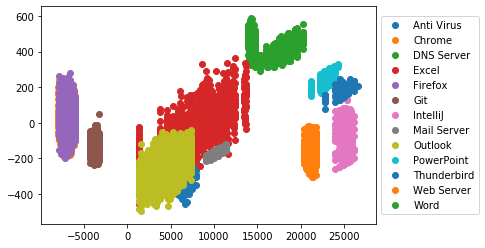

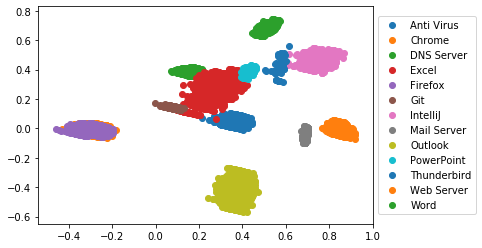

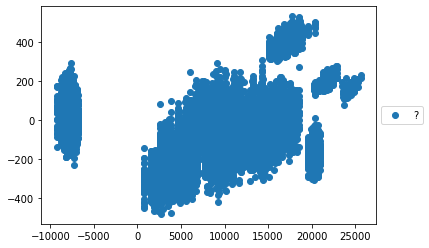

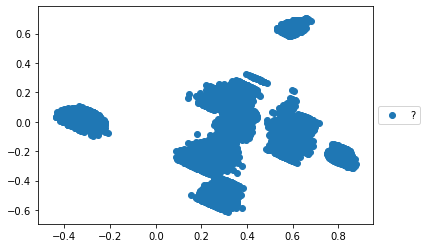

In [7]:
from sklearn.decomposition import PCA
import matplotlib        as mpl
import matplotlib.pyplot as plt
%matplotlib inline

def plot(X, y):
    """Plots the feature vectors given by X and labelled by y.
    
        Parameters
        ----------
        X : array-like of shape=(n_samples, n_features)
            Feature vectors to plot.
        
        y : array-like of shape=(n_features,)
            Labels corresponding to the feature vectors.
        """
    # Transform to numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)
    
    # The PCA(n) takes all features from X and compresses them
    # into n dimensions, in our case to 2 dimensions for plotting.    
    X = PCA(2).fit_transform(X)
    
    # Next for each label, we scatter the corresponding points
    for label in np.unique(y):
        plt.scatter(X[:, 0][y == label], X[:, 1][y == label], label=label)
        
    # Finally we show the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# Plot the data
plot(X_benign, y_benign)          # Plot of features unscaled
plot(X_benign_scaled, y_benign)   # Plot of features scaled
plot(X_unknown, y_unknown)        # Plot of unknown features unscaled
plot(X_unknown_scaled, y_unknown) # Plot of unknown features scaled

**Question 3.3.** Look at the above plots, the first plot is of the unscaled features and the second plot is of the scaled features. As we can see, the scaled features are separated better then the unscaled features. However, are all applications seperated properly? If you see some overlap, is this something you could explain or do you need to choose different features?

**NB:** Note that some overlap might be caused by the dimentionality reduction from the PCA in the plotting method. However, this will very likely result in clusters being very close together, but will likely not result in a *complete* overlap.

not all of the application is seperately properly, it needs more feature because probably some data have the same result hence overlapping

## 4. Model/Parameter selection
Currently we have a matrix stored in the variable `feature_vectors` for which each row contains a data sample, and each column a feature. Now that we have prepared the features that we feed into our NIDS, we have to choose an anomaly detection algorithm to observe new behaviour. Given that we only have access to benign data and unknown data, we cannot train a classifier. Therefore, we need to train a novelty/outlier detection algorithm. In this assignment we will use a One-Class SVM.

As you have learned during the lecture, a One-Class SVM uses a kernel function K to define the geometric relationship between a feature vector X and the support vectors Y. For an RBF (Gaussian) kernel, this relationship is defined as:

$$K(X, Y) = e^{-\frac{||x - y||^2}{2\sigma^2}}$$

**Question 4.1.** Implement the RBF kernel function.

In [8]:
import math
def K(X, Y, sigma=1):
    """RBF (Gaussian) kernel function.
    
        Parameters
        ----------
        X : np.array of shape=(n_features,)
            Vector X for which to compute the RBF kernel function with respect to Y.
            
        Y : np.array of shape=(n_features,)
            Vector Y for which to compute the RBF kernel function with respect to X.
            
        sigma : float, default=1
            Width of each kernel.
            
        Returns
        -------
        result : float
            RBF kernel score.
        """
    #The code between this text should be implemented
#     x = 0
#     y = 0
#     for i in range(len(X)):
#             x += X[i]
#             y += Y[i]
    x = X[-1] - X[0]
    y = Y[-1] - Y[0]
    result = math.exp(-(abs(x-y)**2/(2*sigma)**2)) 
    return result
    # The code between this text should be implemented

A support vector machine (SVM) uses its kernel function to compute a score between a feature vector $X$ and support vector $Y$. You can think of the score as the likelihood **(note that it is not a probability)** that $X$ and $Y$ originate from the same underlying distribution. Because an SVM contains multiple support vectors $Y_i$, we can assign a score to feature vector $X$ based on the likelihood that it shares the same underlying distribution with any of our support vectors $Y_i \in Y$. We compute this overall score by simply adding the (weighted) scores for $X$ with each support vector $Y_i$, which is called the soft score:

$$soft\;score = \sum_{i=0}^N w_iK(X, Y_i)$$

We compare this soft score with a threshold $\tau$ to determine if a point falls within or outside our model. The code below computes the soft score with all weights as 1 for all given points $X$, support vectors $Y$ and kernel $K$.

In [9]:
from sklearn.metrics import pairwise_distances

def soft_score(X, Y, K, **kwargs):
    """Compute the soft score by computing the kernel function
        between each point and each support_vector.
        The scores are then added to create a soft score.
        Note that this function is not weighted, in reality
        weights are added to adjust the importance of each
        support vector.
        
        Parameters
        ----------
        X : np.array of shape=(n_samples, n_features)
            Points for which to compute the soft score.
            
        Y : np.array of shape=(n_samples, n_features)
            Support vectors used to compute the score.
            
        K : func
            Kernel function to compute each individual score.
            
        **kwargs : optional
            Optional arguments for the kernel
            
        Returns
        -------
        result : np.array of shape=(n_samples,)
            Soft score for each point in X.
        """
    # Get vectors as numpy arrays
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Compute scores between each point of X and each support_vector
    scores = pairwise_distances(X, Y, metric=K, **kwargs)
    
    # Compute the added scores
    return scores.sum(axis=1)    

The code snippet below generates random support vectors and shows the soft score values in a plane. All feature vectors that appear in the red area are considered to fall within the soft hypersphere. All feature vecotrs outside the area are considered anomalous.

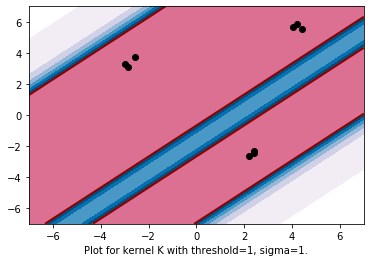

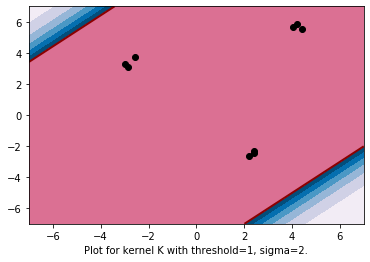

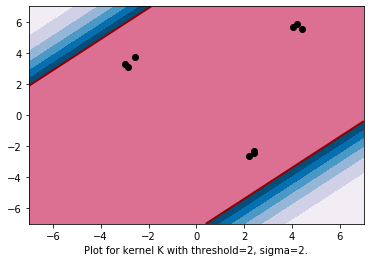

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kernels(support_vectors, K, threshold=2, **kwargs):
    """Function to plot scores and decision boundary for given support vectors.
    
        Parameters
        ----------
        support_vectors : np.array of shape=(n_vectors, n_features)
            Support vectors for which to plot the soft score.
            
        K : func
            Kernel function to compute the soft scores.
            
        threshold : float, default=2
            Decision threshold.
            All scores higher than this threshold will be inside the model.
            All scores lower than this threshold will are anomalous.
            
        **kwargs: optional
            Optional arguments to give to the kernel function K.
        """
    
    # Create meshgrid
    xx, yy = np.meshgrid(np.linspace(-7, 7, 100),
                         np.linspace(-7, 7, 100))
    # Compute decision function
    Z = soft_score(np.c_[xx.ravel(), yy.ravel()], support_vectors, K, **kwargs)
    Z = Z.reshape(xx.shape)

    # Plot smooth contour
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min()+.001, threshold, 7), cmap=plt.cm.PuBu)
    plt.contour (xx, yy, Z, levels=[threshold], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')

    # Plot support vectors
    plt.scatter(support_vectors[:, 0],
                support_vectors[:, 1],
                c='black')
    
    plt.xlabel("Plot for kernel K with threshold={}{}.".format(threshold,
               ", {}".format(", ".join("{}={}".format(k, v) for k, v in sorted(kwargs.items()))) if kwargs else ""))
    
    # Show plot
    plt.show()


# Create seeded randomness generator
random = np.random.RandomState(1)
# Create support vectors to plot
support_vectors = np.concatenate((random.rand(3, 2) + [-3,  3],
                                  random.rand(3, 2) + [ 2, -3],
                                  random.rand(3, 2) + [ 4,  5]))

# Create plots for different threshold and sigma values

plot_kernels(support_vectors, K, threshold=1, sigma=1)
plot_kernels(support_vectors, K, threshold=1, sigma=2)
plot_kernels(support_vectors, K, threshold=2, sigma=2)

**Question 4.2 (Optional)** Create other kernels, e.g. a polynomial kernel and see how the decision bounds change in the plot.

/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/jwicaksana15/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


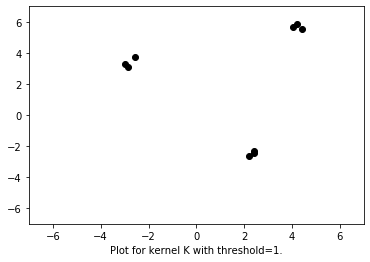

/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/jwicaksana15/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


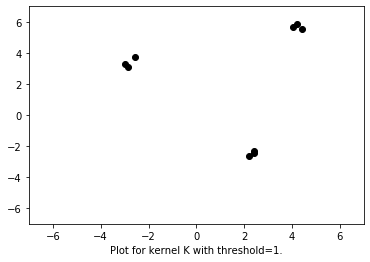

/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/jwicaksana15/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/jwicaksana15/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


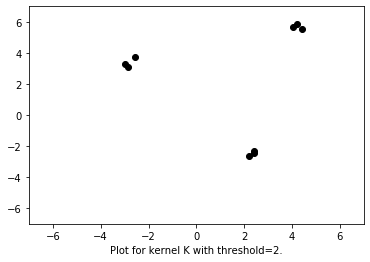

In [11]:
def my_K(X, Y):
    """Your own kernel function.
    
        Parameters
        ----------
        X : np.array of shape=(n_features,)
            Vector X for which to compute the kernel function with respect to Y.
            
        Y : np.array of shape=(n_features,)
            Vector Y for which to compute the kernel function with respect to X.
            
        Returns
        -------
        result : float
            Kernel score.
        """
    # The code between this text should be implemented
    pass
    # The code between this text should be implemented

# Create seeded randomness generator
random = np.random.RandomState(1)
# Create support vectors to plot
support_vectors = np.concatenate((random.rand(3, 2) + [-3,  3],
                                  random.rand(3, 2) + [ 2, -3],
                                  random.rand(3, 2) + [ 4,  5]))

# Create plots for different threshold and sigma values
plot_kernels(support_vectors, my_K, threshold=1)
plot_kernels(support_vectors, my_K, threshold=1)
plot_kernels(support_vectors, my_K, threshold=2)

## 5. Evaluation

Now that we have taken a closer look at One-Class SVMs, we have to think about how we can train, test and evaluate the model. We do this to get an idea of how well the NIDS performs, which allows us to optimise its parameters before deployment and classification of the unknown data. In order to evaluate our model, we require labelled data, i.e. data from the `benign.csv` file. Given that all data is benign, it might seem difficult to do any assessment on whether there are malicious network connections. However, we can think of ways to redefine our problem such that we can only use benign data in order to train and test the NIDS.

All data in the `benign.csv` file is labelled with the corresponding application that produced the data. We know that a malicious program is just another application that we have not seen in our benign data. We will leverage this observation in order to train and test our model.

To this end, we select a portion of labels $L_{train}$ from a dataset $D$, which in our case comes from the `benign.csv` file. Next, we create our training dataset $D_{train}$ by randomly selecting (without replacement) a number of elements from our dataset corresponding to those labels. Our dataset $D_{test}$ is composed of all the elements in $D$ that have not been selected for $D_{train}$, i.e. $D_{test} = D \setminus D_{train}$. This means that $D_{train}$ contains datapoints with labels $L_{train}$ and $D_{test}$ contains datapoints with labels from all labels in our dataset $D$. Figure 2 gives a visual representation of an example split.

<img src="split.png" width=600>
<div align="center">Figure 2. Example split where Labels $1$, $2$, and $5$ are selected for training and Labels $3$ and $4$ are selected for testing.</div>

As an example, suppose that we have a dataset from 4 applications: $L = \lbrace \text{Firefox}, \text{Word}, \text{Git}, \text{Excel} \rbrace$. Now we randomly select (without replacement) half of the labels to fit into $L_{train}$. E.g. we select $L_{train} = \lbrace \text{Firefox}, \text{Excel} \rbrace$. Next we define a training dataset $D_{train}$ containing random elements from our `benign.csv` dataset that have a corresponding label of Firefox or Excel. Finally, we use all of the remaining datapoints for $D_{test}$.

**Question 5.1.** Implement the function `split_train_test` that implements the split technique described above.

*(Hint: see [Numpy RandomState](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.RandomState.html#numpy.random.RandomState)) for reproducable randomness.)*

In [12]:
def split_train_test(X, y, label_train_size=3/4, data_train_size=3/4, random_seed=42):
    """Takes data and labels and splits it into training and testing data and labels.

        Parameters
        ----------
        X : np.array of shape=(n_samples, n_features)
            Data to split into training and testing sets.
            
        y : np.array of shape=(n_samples,)
            Labels to split into training and testing sets.
            
        label_train_size : float, default=3/4
            Proportion of labels to train with.
            
        data_train_size : float, default=3/4
            Proportion of data with training_label to train with.
            
        random_seed : int, default=42
            Seed to use in your random function, for reproducability.

        Returns
        -------
        X_train : np.array of shape=(n_samples_train, n_features)
            Training data obtained by split.
            
        y_train : np.array of shape=(n_samples_train,)
            Training labels obtained by split.
            
        X_test : np.array of shape=(n_samples_test, n_features)
            Testing data obtained by split.
            
        y_test : np.array of shape=(n_samples_test,)
            Testing labels obtained by split.
    """
    
    # The code between this text should be implemented
    
    
    #======================INITIALIZE========================
    # Use this object for generating pseudo randomness
    random = np.random.RandomState(random_seed)
    reshapeY = y.reshape(y.shape[0], 1)#so the y has 2 dimension
    combineArrayXY = np.concatenate((reshapeY, X), axis=1)#combine label and data into datasets
    valueYTrain = 0 #value for how many label in y label
    
    #print(combineArrayXY)
    
    #======================Y_TRAIN===========================
    newY = list(set(y)) #duplicate removed then change into list
    newY.sort() #sort so it always show the same list
    arrayY = np.asarray(newY) #remove duplicates of y label -> convert into list -> numpy array
    trainY = round(label_train_size*arrayY.shape[0])#get how many label to be trained and round to nearest decimal
    labelRChoice = random.choice(arrayY, trainY, replace=False)#pseudo randomly choose 3/4 from 13 apps
    y_train = labelRChoice
#     print(labelRChoice)
#     print(arrayY)
#     print(newY)
    
    #======================Y_TRAIN_LIST===========================
    yTestList = list(set(y)) #to be used to get 3 distinct labels
    yTestLabel = [] #all of the labels for testing
    for i in labelRChoice: #to remove 9 train labels and get 1/4 of each labels to yTestLabel
        yTestList.remove(i) #remove 9 train labels
        valueYTrain = y.tolist().count(i) - round(y.tolist().count(i)*label_train_size) #subtract original amount by rounded 3/4 of each labels
        for j in range(valueYTrain):
            yTestLabel.append(i)
        
    for i in yTestList: #iterate for given distinct 3 labels
        valueYTrain = y.tolist().count(i) #get total data for each labels
        for j in range(valueYTrain): #append yTestLabel
            yTestLabel.append(i)
    
#     print(yTestList)
#     print(len(yTestLabel))
    
    #======================X_TRAIN===========================   
#     for i in combinArrayXY:
    combineArrayXY = combineArrayXY.T#transpose
#     combineArrayXY = np.insert(combineArrayXY,0,2,axis=1)#insert 2 into the first column
#     combineArrayXY = np.insert(combineArrayXY,1,2,axis=1)
#     print(combineArrayXY[0])  
#     print(combineArrayXY.shape)

    #first method
    for i in yTestLabel: #get all app names in y_test
        a = True 
        j = 0
        while(a):#everytime meets the word get out of the loop else search for significane 1 word
            if combineArrayXY[0][j] == i:#check only the app rows and check if it is the same
                combineArrayXY[0][j] = 2#change the value of same valu with i(label in ytest) into 2
                a = False
            j += 1
        
    X_train = combineArrayXY[:,combineArrayXY[0]!= 2]#numpy boolean detection to remove 2
    X_train = np.delete(X_train, 0, 0)#delete the albels
    X_train = X_train.T#transpose (c,r) ->(r,c)
    #print(X_train)  
#     print(X_train.shape)

    #second method
#     for i in list(set(yTestLabel)):
#         eachLabel = list(yTestLabel).count(i)
#         print(eachLabel)
#         iterate = 0
#         while(iterate < eachLabel):
#             for j in range(X.shape[0]):
#                 if combineArrayXY[0][j] is i:
#                     combineArrayXY[0][j] = 2
#                     iterate += 1
                    
#     combineArrayXY = combineArrayXY[:,combineArrayXY[0] != 2]#numpy boolean detection to remove 2
#     print(combineArrayXY[0])  
#     print(combineArrayXY.shape)
    #======================Y_TEST============================   
    y_test = np.asarray(yTestLabel)
    
    #======================X_TEST============================ 
    X_test = combineArrayXY[:,combineArrayXY[0]==2]#delete train values
    X_test = np.delete(X_test, 0, 0)#delete the labels
    X_test = X_test.T#transpose (c,r) -> (r,c)
#     print(X_test)
#     print(X_test.shape)
                
    
    
    return X_train, y_train, X_test, y_test

    # The code between this text should be implemented

# Get the 
X_train, y_train, X_test, y_test = split_train_test(X_benign_scaled, y_benign, random_seed=42)
# Ensure the samples are numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test )
y_test  = np.asarray(y_test )

# Shows all labels in training set
apps_all     = np.unique(y_benign)
apps_trained = set(apps_all[np.isin(apps_all, y_train)])

print("{:20} | {} | {}".format("Application", "In train set", "In test set"))
print("-------------------------------------------------")
for app in sorted(apps_all):
    print("{:20} | {:>12} | {:>11}".format(app, str(app in apps_trained), str(app in apps_all)))

Application          | In train set | In test set
-------------------------------------------------
Anti Virus           |         True |        True
Chrome               |         True |        True
DNS Server           |         True |        True
Excel                |        False |        True
Firefox              |         True |        True
Git                  |         True |        True
IntelliJ             |        False |        True
Mail Server          |         True |        True
Outlook              |         True |        True
PowerPoint           |         True |        True
Thunderbird          |        False |        True
Web Server           |         True |        True
Word                 |         True |        True


Given these test and training datasets we can evaluate our chosen model on the `benign.csv` dataset before we will apply it to the `unknown.csv` dataset. However, before we evaluate this model, we actually have to train it and give out a prediction. To this end, we will use the [Scikit-Learn - OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) implementation of the One-Class SVM. This model needs to be fitted with train data of known classes. Subsequently it will predict testing samples as +1 if they fit the known model, or -1 if they are considered anomalous.

**Question 5.2.** Import the One-class SVM from [Scikit-Learn - OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM), train it with `X_train` and let it make a prediction on the `X_test` data. Note that the `gamma` parameter for the RBF kernel in this library is defined as $\gamma = \frac{1}{2\sigma^2}$. Therefore its RBF kernel is defined as:

$$K(X, Y) = e^{-\gamma||x - y||^2}$$

In [13]:
# Answer question 5.2 here.

from sklearn.svm import OneClassSVM

class NIDS(object):
    
    def __init__(self):
        """Network Intrusion Detection System (NIDS).
            This code is executed when you create a new NIDS object.
            Here you can create a new instance of the OneClassSVM
            """
        # The code between this text should be implemented
        self.SVM = OneClassSVM
        # The code between this text should be implemented
    
    def train(self, X):
        """Train your NIDS by fitting the classifier.
        
            Parameters
            ----------
            X : array-like of shape=(n_samples, n_features)
                Data used to train your classifier.
            """
        # The code between this text should be implemented
        print(X.shape[1])
        n_feature = X.shape[1]
        self.gamma = 1/(n_feature*X.var())
        self.train = self.SVM(nu=0.00177, gamma= 12).fit(X)
        # The code between this text should be implemented
    
    def predict(self, X):
        """Predict samples using your NIDS.
        
            Parameters
            ----------
            X : array-like of shape=(n_samples, n_features)
                Data which your classifier should predict
                
            Returns
            -------
            result : np.array of shape=(n_samples,)
                Output labels of +1 if known or -1 if anomaly.
            """
        # The code between this text should be implemented
        predict = self.train.predict(X)
        return predict
        # The code between this text should be implemented
        
# Create NIDS
nids = NIDS()
# Fit NIDS classifier with training data
nids.train(X_train)
# Perform prediction
prediction = nids.predict(X_test)

# Show the amount of samples predicted as normal/anomalous
print("Predicted known   samples: {}".format(np.sum(prediction ==  1)))
print("Predicted unknown samples: {}".format(np.sum(prediction == -1)))


5
Predicted known   samples: 9620
Predicted unknown samples: 2152


The prediction algorithm outputs labels of +1 (known) when a sample fits the training data and -1 (unknown) when a sample does not fit the training data. In order for us to compare the predictions with the actual labels, we have to transform the labels to +1 in case they are in the training dataset or -1 in case they are not the training dataset.
The code below transform your labels to +1 if they are in `y_train` and to -1 otherwise by implementing `get_label_as_prediction`.

In [14]:
def get_label_as_prediction(labels, y_train):
    """Transforms labels into values of +1 in case they are in y_train
       or -1 in case they are not in y_train.
       
        Parameters
        ----------
        labels : array-like of shape=(n_features,)
            Labels to transform into +1 or -1.
           
        y_train : array-like of shape=(n_features,)
            Labels used for training.
        """
    # Transform into numpy array
    labels  = np.asarray(labels)
    y_train = np.asarray(y_train)

    return np.where(np.isin(labels, np.unique(y_train)), 1, -1)

y_test_as_pred  = get_label_as_prediction(y_test , y_train)
y_train_as_pred = get_label_as_prediction(y_train, y_train)
print(np.sum(y_test_as_pred == 1))
print(np.sum(y_test_as_pred == -1))

9785
1987


Given the prediction of our anomaly detector we can compute a number of metrics to evaluate our classification. Most metrics used for evaluation of classifiers are based on 4 possible outcomes of the classification:
 * True Positives (TP), the amount of samples labelled as *unknown*, that should be labelled as *unknown*.
 * True Negatives (TN), the amount of samples labelled as *known*, that should be labelled as *known*.
 * False Positives (FP), the amount of samples labelled as *unknown*, that should be labelled as *known*.
 * False Negatives (FN), the amount of samples labelled as *known*, that should be labelled as *unknown*.
 
Or in a diagram:

| $ $                | Expected Unknown | Expected Known |
|--------------------|------------------|----------------|
| Predicted Unknown  | TP               | FP             |
| Predicted Known    | FN               | TN             |

**Question 5.3.** Given these definitions of TP, TN, FP, FN, implement the methods that compute them given the predictions and actual labels.

In [15]:
def TP(predictions, labels):
    """Computes the amount of True Positives.
    
        Parameters
        ----------
        predictions : array-like of shape=(n_samples,)
            Predicted values over which to compute True Positives.
            
        labels : array-like of shape=(n_samples,)
            Actual values over which to compute True Positives.
            
        Returns
        -------
        result : int
            Number of True Positive labels.
        """
    # The code between this text should be implemented
    a = []
    for i in range(len(predictions)):
        if predictions[i] == labels[i]:
            a.append(predictions[i])
    a = np.asarray(a)
    result = np.sum(a == -1)
    print(result)
    return result
    # The code between this text should be implemented

def TN(predictions, labels):
    """Computes the amount of True Negatives.
    
        Parameters
        ----------
        predictions : array-like of shape=(n_samples,)
            Predicted values over which to compute True Negatives.
            
        labels : array-like of shape=(n_samples,)
            Actual values over which to compute True Negatives.
            
        Returns
        -------
        result : int
            Number of True Negatives labels.
        """
    # The code between this text should be implemented
    a = []
    for i in range(len(predictions)):
        if predictions[i] == labels[i]:
            a.append(predictions[i])
    a = np.asarray(a)
    result = np.sum(a == 1)
    return result
    # The code between this text should be implemented

def FP(predictions, labels):
    """Computes the amount of False Positives.
    
        Parameters
        ----------
        predictions : array-like of shape=(n_samples,)
            Predicted values over which to compute False Positives.
            
        labels : array-like of shape=(n_samples,)
            Actual values over which to compute False Positives.
            
        Returns
        -------
        result : int
            Number of False Positive labels.
        """
    # The code between this text should be implemented
    a = []
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            a.append(predictions[i])
    a = np.asarray(a)
    result = np.sum(a == -1)
    return result
    # The code between this text should be implemented

def FN(predictions, labels):
    """Computes the amount of False Negatives.
    
        Parameters
        ----------
        predictions :  array-like of shape=(n_samples,)
            Predicted values over which to compute False Negatives.
            
        labels : array-like of shape=(n_samples,)
            Actual values over which to compute False Negatives.
            
        Returns
        -------
        result : int
            Number of False Negatives labels.
        """
    # The code between this text should be implemented    l
    a = []
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            a.append(predictions[i])
    a = np.asarray(a)
    result = np.sum(a == 1)
    return result
    # The code between this text should be implemented

From the implementation of True/False Positive/Negative values we can derrive several metrics. There are various metrics that are used widely in the evaluation of machine learning techniques. We will discuss and implement 5 of these.

The True Positive Rate (TPR), also called sensitivity, measures the proportion of actual positives that are correctly identified as such.
$$TPR = \frac{TP}{TP+FN} = 1-FNR$$

The True Negative Rate (TNR), also called specificity, measures the proportion of actual negatives that are correctly identified as such.
$$TNR = \frac{TN}{TN+FP} = 1-FPR$$

The False Positive Rate (FPR), measures the proportion of actual negatives that are identified as positives. If a NIDS has a high FPR, it will not find malicious software, making it useless.
$$FPR = \frac{FP}{TN+FP} = 1-TNR$$

The False Negative Rate (FNR), measures the proportion of actual positives that are identified as negatives. If a NIDS has a high FNR, it will raise alarms for benign network traffic, causing a lot of frustration for the people on the network.
$$FNR = \frac{FN}{TP+FN} = 1-TPR$$

The Accuracy (ACC) combines the TPR and FPR to get a complete overview of the system performance. An accuracy of 1.0 means everything is correctly classified. An accuracy of 0.0 means nothing is correctly classified.
$$ACC = \frac{TP+TN}{TP+TN+FP+FN}$$

**Question 5.4.** Implement the 5 metrics according to their definitions.

In [16]:
def TPR(predictions, labels):
    """Computes the True Positive Rate.
    
        Parameters
        ----------
        predictions : np.array of shape=(n_samples,)
            Predicted values over which to compute TPR.
            
        labels : np.array of shape=(n_samples,)
            Actual values over which to compute TPR.
            
        Returns
        -------
        result : float
            True Positive Rate.
        """
    # The code between this text should be implemented
    tp = TP(predictions, labels)
    fn = FN(predictions, labels)
    result = tp/(tp+fn)
    return result
    # The code between this text should be implemented

def TNR(predictions, labels):
    """Computes the True Negative Rate.
    
        Parameters
        ----------
        predictions : np.array of shape=(n_samples,)
            Predicted values over which to compute TNR.
            
        labels : np.array of shape=(n_samples,)
            Actual values over which to compute TNR.
            
        Returns
        -------
        result : float
            True Negative Rate.
        """
    # The code between this text should be implemented
    tn = TN(predictions, labels)
    fp = FP(predictions, labels)
    result = tn/(tn+fp)
    return result
    # The code between this text should be implemented

def FPR(predictions, labels):
    """Computes the False Positive Rate.
    
        Parameters
        ----------
        predictions : np.array of shape=(n_samples,)
            Predicted values over which to compute FPR.
            
        labels : np.array of shape=(n_samples,)
            Actual values over which to compute FPR.
            
        Returns
        -------
        result : float
            False Positive Rate.
        """
    # The code between this text should be implemented
    fp = FP(predictions, labels)
    tn = TN(predictions, labels)
    result = fp/(fp+tn)
    return result
    # The code between this text should be implemented

def FNR(predictions, labels):
    """Computes the False Negative Rate.
    
        Parameters
        ----------
        predictions : np.array of shape=(n_samples,)
            Predicted values over which to compute FNR.
            
        labels : np.array of shape=(n_samples,)
            Actual values over which to compute FNR.
            
        Returns
        -------
        result : float
            False Negative Rate.
        """
    # The code between this text should be implemented
    fn = FN(predictions, labels)
    tp = TP(predictions, labels)
    result = fn/(fn+tp)
    return result
    # The code between this text should be implemented

def ACC(predictions, labels):
    """Computes the Accuracy.
    
        Parameters
        ----------
        predictions : np.array of shape=(n_samples,)
            Predicted values over which to compute ACC.
            
        labels : np.array of shape=(n_samples,)
            Actual values over which to compute ACC.
            
        Returns
        -------
        result : float
            Accuracy.
        """
    # The code between this text should be implemented
    tn = TN(predictions, labels)
    tp = TP(predictions, labels)
    fn = FN(predictions, labels)
    fp = FP(predictions, labels)
    result = (tp+tn)/(tp+tn+fp+fn)
    print(tn, tp, fn, fp)
    return result
    # The code between this text should be implemented

    
def print_metrics(predictions, labels):
    """Prints the metrics for given predictions and true labels.
    
        Parameters
        ----------
        predictions : array-like of shape=(n_samples,)
            Predictions of your classifier
            
        labels : array-like of shape=(n_samples,)
            Actual labels for the predicted data
        """
    # Print all metrics in a table
    print("Metric | Value")
    print("-----------------")
    print("TPR    | {}".format(TPR(predictions, labels)))
    print("TNR    | {}".format(TNR(predictions, labels)))
    print("FPR    | {}".format(FPR(predictions, labels)))
    print("FNR    | {}".format(FNR(predictions, labels)))
    print("ACC    | {}".format(ACC(predictions, labels)))
    
# Show metrics
print_metrics(prediction, y_test_as_pred)

Metric | Value
-----------------
631
TPR    | 0.3175641670860594
TNR    | 0.8445579969340827
FPR    | 0.1554420030659172
631
FNR    | 0.6824358329139406
631
8264 631 1356 1521
ACC    | 0.7556065239551478


## 6. Optimisation
**Question 6.1.** Look at the performance of your NIDS (given by the metrics), can you improve the performance? Perform the experiment again with different parameter settings and try to find parameters which give an accuracy of $\geq$ 95% and a False Positive Rate of $\leq$ 2%.

*(Hint: If you cannot seem to get a good performance, perhaps the features that you have chosen for your NIDS in sections 1 and 2 need to be improved, or the model parameters that you have chosen in section 5 is not suitable for the NIDS.)*

**Question 6.2.** Once you get a high accuracy, experiment with different `random_seed` values for the `split_train_test` method. This will split the dataset differently. If you suddenly see a drop in the performance of your NIDS, it means that you have overfitted your model. Try to optimise the parameters of your NIDS such that it is robust against overfitting.

*(Hint: As we have seen in question 3.3, some applications are very much alike. If you see a huge drop in performance, go back and see how the applications were split into training and testing applications. There might be applications that are too alike to distinguish. Unfortunately, we cannot do anything about this.)*

**Question 6.3.** Suppose that one of the desktop machines in your network has 2 applications installed $A_1$ and $A_2$. Now also suppose that the server in your network has installed the application $A_3$. Suddenly, the desktop machine starts to behave as if it was running $A_3$, would your NIDS be able to detect this?

no if it has the similar packet size and timestamp it would be not possible

**Question 6.4. (optional)** Try to redesign your NIDS in such a way that it will be able to detect new (i.e. malicious) applications on a per machine basis. Also try to come up with a way of testing whether your new NIDS is capable of detecting the scenario described in 6.3.

**Hints:**
 1. Use a different anomaly detector for each machine.
 2. Think about which feature you can use to divide samples over each classifier.

In [17]:
# Answer question 6.4 here.

from sklearn.svm import OneClassSVM

class NIDS_multiclass(object):
    
    def __init__(self):
        """Network Intrusion Detection System (NIDS).
            This code is executed when you create a new NIDS object.
            Here you can create classifiers per machine
            """
        # The code between this text should be implemented
        pass
        # The code between this text should be implemented
    
    def train(self, X):
        """Train your NIDS by fitting the classifier(s).
        
            Parameters
            ----------
            X : array-like of shape=(n_samples, n_features)
                Data used to train your classifier(s).
            """
        # The code between this text should be implemented
        pass
        # The code between this text should be implemented
    
    def predict(self, X):
        """Predict samples using your NIDS.
        
            Parameters
            ----------
            X : array-like of shape=(n_samples, n_features)
                Data which your classifier(s) should predict
                
            Returns
            -------
            result : np.array of shape=(n_samples,)
                Output labels of +1 if known or -1 if anomaly.
            """
        # The code between this text should be implemented
        pass
        # The code between this text should be implemented

# The code between this text should be implemented to test the scenario from Question 6.3.
pass
# The code between this text should be implemented to test the scenario from Question 6.3.


# Create NIDS
nids = NIDS_multiclass()
# Fit NIDS classifier with training data
nids.train(<your_training_samples>)
# Perform prediction
prediction = nids.predict(<your_training_samples>)

# Show performance
print_metrics(prediction, <your_testing_labels>)

SyntaxError: invalid syntax (<ipython-input-17-f1e61a85e167>, line 53)

## 7. Passing the assignment
You have created a NIDS which is optimised for the data from `benign.csv`, now we will use this NIDS to predict whether messages from the dataset `unknown.csv` are benign (+1) or malicious (-1). To check the performance of your NIDS and whether you passed the assignment we use the `submit` method. This method submits your prediction to our server which checks the performance.

**NB:** the `submit` method requires internet access.

In [18]:
import requests
import json

def submit(prediction, student_number, highscore_name=None):
    """Submit your prediction to the server to check if the prediction of your unknown data is correct.
        The result will print whether you passed the assignment or not.
    
        Parameters
        ----------
        prediction : array-like of shape=(n_samples_unknown,)
            Prediction of unknown datapoints.
            
        student_number : string
            Your student number as a string, e.g., 's1234567'
            Please use your actual student number, we have build in 
        
        highscore_name : string, optional
            If given, your performance will be published on the highscore page under this name
        """
    # Get prediction as list
    prediction = np.asarray(prediction, dtype=int).tolist()
    # Create JSON data to send
    data = {"prediction"    : prediction,
            "student_number": student_number,
            "name"          : highscore_name}
    # Submit data
    r = requests.post("https://vm-thijs.ewi.utwente.nl/ml/submit/", json=data)
    # Read response
    r = json.loads(r.text)
    
    # Print errors if any
    if len(r.get('errors', [])) > 0:
        print("Errors found:")
        for error in r.get('errors'):
            print("    - {}".format(error))
        print()
    
    # Show performance
    print("Metrics | Value")
    print("-----------------")
    print("TPR      | {:10.7}".format(r.get('TPR', float('NaN'))))
    print("TNR      | {:10.7}".format(r.get('TNR', float('NaN'))))
    print("FPR      | {:10.7}".format(r.get('FPR', float('NaN'))))
    print("FNR      | {:10.7}".format(r.get('FNR', float('NaN'))))
    print("ACC      | {:10.7}".format(r.get('ACC', float('NaN'))))
    print()
    
    # Check if you passed
    if r.get('ACC', 0) > 0.90 and r.get('FPR', 1) < 0.05:
        print("You have passed the assignment!")
    else:
        print("You have not yet passed the assignment.")

**Question 7.1.** Make a prediction on the data from the `unknown.csv` dataset and call the method `submit` with your answer. It will display the performance of your NIDS. If you achieve an accuracy of $\geq$ 90% with a False Positive Rate of $\leq$ 5%, you have passed the assignment.

**Important notices:**
 1. We store your submissions on our server and these values will be used to check if you passed the assignment or not. Therefore, make sure that you submit your prediction correctly using the `submit` method. If any error occurs, the error message will be printed. If you are unable to fix these error messages, please contact the TA at [t.s.vanede@utwente.nl](mailto:t.s.vanede@utwente.nl).
 2. The `check_prediction` method requires internet access.
 3. This assignment is graded individually. Please use your actual student number, e.g. `s1234567` and only your own student number. We log each sign of misconduct.
 4. If you want to participate in the highscores, please provide a `highscore_name`. If you **do not** want your name to appear in the highscores please leave this field to `None`. You can check the highscores at [vm-thijs.ewi.utwente.nl/ml/](https://vm-thijs.ewi.utwente.nl/ml/).

In [19]:
# Answer Question 7.1 here

nids = NIDS()
# Fit NIDS classifier with training data
nids.train(X_benign_scaled)               # Important to train with the scaled data
# Perform prediction
prediction = nids.predict(X_unknown_scaled)    # Important to predict the entire scaled unknown data

# Will show you whether you passed the assignment
# Note: Change "<your_student_number>" with your student number as a string
# Note: Only set a highscore_name if you want to participate in the highscore ranking
submit(prediction, student_number="s2096862", highscore_name=None)

5
Errors found:
    - Your solution is already registered in the database and you passed. If you want to submit again, try a different/improved solution.

Metrics | Value
-----------------
TPR      |    0.72159
TNR      |  0.9626627
FPR      | 0.03733728
FNR      |    0.27841
ACC      |  0.9256672

You have passed the assignment!
